# 量子回路学習

In [1]:
from qiskit import * 
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import I, Z
from qiskit.aqua.operators.state_fns import StateFn, CircuitStateFn
from qiskit.aqua.operators.expectations import PauliExpectation, AerPauliExpectation
from qiskit.aqua.operators.converters import CircuitSampler
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)

## 乱数のシード
random_seed = 0
## 乱数発生器の初期化
np.random.seed(random_seed)

## 教師データの準備

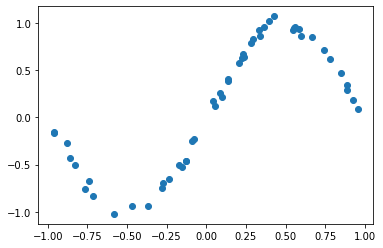

In [3]:
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定しノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

## 期待値を求める関数の実装

In [4]:
def get_expectation_val(psi, op):
    # define your backend or quantum instance
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1024)
    
    # define the state to sample
    measurable_expression = StateFn(op, is_measurement=True).compose(psi) 

    # convert to expectation value
    expectation = PauliExpectation().convert(measurable_expression)  
#     expectation = AerPauliExpectation().convert(measurable_expression)

    # get state sampler (you can also pass the backend directly)
    sampler = CircuitSampler(q_instance).convert(expectation) 

    # evaluate
    return sampler.eval().real

## 初期値$x_i$をエンコードする関数の実装

In [5]:
def U_in(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.ry(angle_y, i)
        U.rz(angle_z, i)
        
    return U

## 量子回路の構築

### パラメータの準備

In [6]:
# 横磁場イジングモデルのパラメーター
time_step = 0.77  # ランダムハミルトニアンによる時間発展の経過時間
M = 2 # トロッター分解の分割数
delta = time_step/M # 時間の刻み幅
h = 3 # 外部磁場

# 回転ゲートのパラメーター
param_list = ParameterVector('theta', c_depth*nqubit*3)

In [7]:
def U_out():
    qc = QuantumCircuit(nqubit)
    
    for d in range(c_depth):
        for s in range(M):
            # トロッター分解の1回分、
            for i in range(nqubit):
                qc.cx(i,(i+1)%nqubit)
                qc.rz(-2*delta,(i+1)%nqubit)
                qc.cx(i,(i+1)%nqubit)
                qc.rx(-2*delta*h, i)

        # 回転ゲートを導入
        for i in range(nqubit):
            qc.rx(-2*param_list[3*(nqubit*d+i)], i)            
            qc.rz(-2*param_list[3*(nqubit*d+i)+1], i)
            qc.rx(-2*param_list[3*(nqubit*d+i)+2], i)
    return qc

In [8]:
# モデルの出力
# 出力状態において最初の量子ビットのZでの期待値を計算
from qiskit.aqua.operators import Z, I

def qcl_pred(x, param_dict):
    qcl_cirq = U_in(x) + U_out()
    qcl_cirq.assign_parameters(param_dict, inplace=True)
    op = Z ^ I ^ I
    psi = StateFn(qcl_cirq)
    return  2 * get_expectation_val(psi, op)

In [9]:
# cost function Lを計算
def cost_func(theta_list):

    param_dict = dict(zip(param_list.params, theta_list))
    
    # num_x_train個のデータについて計算
    y_pred = [qcl_pred(x, param_dict) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

In [10]:
# パラメータthetaの初期値theta_initにおけるコスト関数の値
# theta: 長さc_depth * nqubit * 3のndarray
theta_init = [2.0 * np.pi * np.random.rand() for i in range(c_depth*nqubit*3)]
cost_func(theta_init)

1.0270514865088487

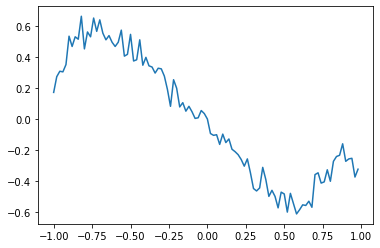

In [13]:
# パラメータthetaの初期値のもとでのグラフ
xlist = np.arange(x_min, x_max, 0.02)
theta_init_dict = dict(zip(param_list.params, theta_init))
y_init = [qcl_pred(x, theta_init_dict) for x in xlist]
plt.plot(xlist, y_init)

In [14]:
from scipy.optimize import minimize
# 学習(注意:2.5時間かかりました)
result = minimize(cost_func, theta_init, method='Nelder-Mead')
theta_opt = result.x
print(theta_opt)

[5.06950285 3.64168667 5.2569088  4.44711444 4.5914524  3.32920298
 5.56411702 3.85617943 2.43791329 3.95318329 0.12895573 1.86287913
 4.20712803 1.86422959 4.00780984 2.53630457 0.86034783 1.89385077
 3.57809699 3.81443742 3.71497123 4.13100258 4.17528646 2.70923358
 5.88777711 2.23311783 2.92295646]


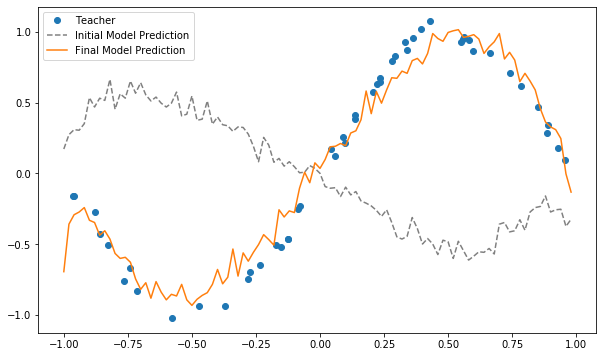

In [16]:
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# パラメータθの初期値のもとでのグラフ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# モデルの予測値
theta_opt_dict = dict(zip(param_list.params, theta_opt))
y_pred = np.array([qcl_pred(x, theta_opt_dict) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()

In [ ]:
20:57 23:30